In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import seaborn as sn
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import time
import os

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv('/kaggle/input/l12data/train.csv')
valid = pd.read_csv('/kaggle/input/l12data/valid.csv')
test = pd.read_csv('/kaggle/input/l12data/test.csv')

In [4]:
train.shape

(28520, 772)

In [5]:
svm = SVC(kernel='linear')
def svm_classifier(X_train, Y_train, X_val, Y_val):
    svm.fit(X_train, Y_train)

    y_pred = svm.predict(X_val)

    accuracy = accuracy_score(Y_val, y_pred)
    return accuracy

In [6]:
knn = KNeighborsClassifier(n_neighbors=1)
def knn_classifier(X_train, Y_train, X_val, Y_val):

    knn.fit(np.array(X_train), Y_train)

    y_pred = knn.predict(np.array(X_val))

    accuracy = accuracy_score(Y_val, y_pred)
    return accuracy

In [7]:
logreg = LogisticRegression()
def logistic_regression_classifier(X_train, Y_train, X_val, Y_val):

    logreg.fit(X_train, Y_train)

    y_pred = logreg.predict(X_val)

    accuracy = accuracy_score(Y_val, y_pred)
    return accuracy

In [8]:
catboost = CatBoostClassifier()

def catboost_classifier(X_train, Y_train, X_val, Y_val):

    catboost.fit(X_train, Y_train)

    y_pred = catboost.predict(X_val)

    accuracy = accuracy_score(Y_val, y_pred)
    return accuracy

In [9]:
def id_highly_correlated_features(dataset, threshold):
    corr_matrix = dataset.corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]
    return set(to_drop)

In [10]:
def id_weekly_correlated_features_with_label(dataset, label, threshold = 0.01):
    for label_ in train.iloc[:, -4:]:
        if label_ != label:
            dataset = dataset.drop(label_, axis=1)  # remove other targets from the dataset
    corr_matrix = dataset.corr().abs()
    weak_corr_features = corr_matrix[corr_matrix[label] < threshold].index.tolist()
    if label in weak_corr_features:
        weak_corr_features.remove(label)
    return weak_corr_features

# Label 1

In [11]:
label_1_train = train.copy()
label_1_valid = valid.copy()
label_1_test = test.copy()

In [12]:
label_1_train = label_1_train.dropna(subset=['label_1'])
label_1_valid = label_1_valid.dropna(subset=['label_1'])

In [13]:
label_1_test.head()

,ID,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_759,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767,feature_768
0,1,0.124623,0.196628,0.257004,-0.156045,-0.054916,0.006071,-0.035149,-0.092019,-0.196302,...,-0.221466,0.140292,0.123622,-0.175572,-0.107030,-0.087621,-0.026501,0.139337,-0.083030,0.059507
1,2,0.109655,0.170158,0.227644,-0.127088,-0.044476,-0.046852,-0.090026,-0.061321,-0.227288,...,-0.204930,0.110203,0.085665,-0.286787,-0.113195,-0.057312,-0.055680,0.143939,-0.045760,0.106113
2,3,0.014854,0.030051,0.115092,-0.017179,0.002720,-0.011692,-0.078855,-0.042991,-0.096283,...,-0.032937,0.075821,0.030987,-0.149850,-0.003155,-0.010207,-0.001427,0.000934,-0.017069,0.048123
3,4,0.196893,0.113314,0.352175,-0.108499,-0.064472,-0.073239,-0.086402,0.008671,-0.342217,...,-0.255167,0.096579,0.069413,-0.215386,-0.075168,-0.035071,-0.023375,0.067768,-0.181530,0.174444
4,5,0.033004,0.013373,0.124001,-0.016143,0.010120,0.010635,-0.055789,-0.036282,-0.059422,...,-0.035814,0.093764,0.027321,-0.116009,0.010096,-0.042293,0.005347,0.007722,-0.007731,0.058799


In [14]:
X_train = label_1_train.iloc[:, :-4]
y_train = label_1_train.iloc[:, -4:]
X_val = label_1_valid.iloc[:, :-4]
y_val = label_1_valid.iloc[:, -4:]
X_test = label_1_test.iloc[:, 1:]

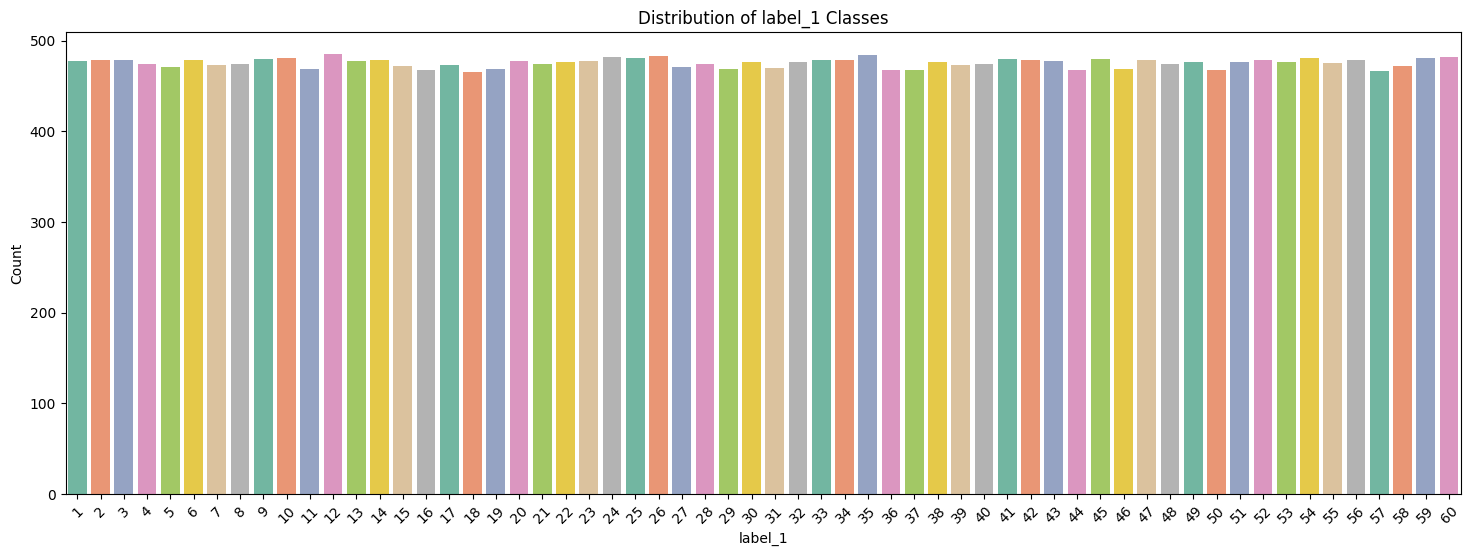

In [15]:
plt.figure(figsize=(18, 6))
sn.countplot(data=y_train, x='label_1', palette='Set2')
plt.title('Distribution of label_1 Classes')
plt.xlabel('label_1')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [16]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [17]:
X_train_scaled.shape

(28520, 768)

In [18]:
pca = PCA(n_components=0.99, svd_solver = 'full')
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

In [19]:
X_train_pca.shape

(28520, 314)

In [20]:
# # defining parameter range
# param_grid = {'depth': [6, 8],
#               'learning_rate' : [0.01, 0.05, 0.1],
#               'iterations': [100]}

# # Create a CatBoostClassifier object
# cb = CatBoostClassifier(task_type="GPU")

# # Create GridSearchCV object
# grid = GridSearchCV(cb, param_grid, cv=3, verbose=2)

# # fitting the model for grid search
# grid.fit(X_train_pca, y_train['label_1'])

# # get the best parameters
# grid.best_params_


In [21]:
# # Define parameter range
# param_grid = {'C': [100,1000], 
#               'gamma': [ 0.1, 0.01],
#               'kernel': ['rbf']}

# # Create a SVM object
# svc = SVC()

# # Create GridSearchCV object
# grid = GridSearchCV(svc, param_grid, cv=3, verbose=2)

# # Fit the model for grid search
# grid.fit(X_train_pca, y_train['label_1'])

# # Get the best parameters
# grid.best_params_

In [22]:
# # Create a CatBoostClassifier object
# cb = CatBoostClassifier(depth=6, learning_rate=0.1, iterations=100,task_type="GPU")

# # Perform cross-validation and compute the mean score
# mean_score = cross_val_score(cb, X_train_pca, y_train['label_1'], cv=3).mean()

In [23]:
cross_val_score(SVC(C=1000, gamma=0.01, kernel='rbf'), X_train_pca, y_train['label_1'], cv=3).mean()

0.9050139438671847

In [24]:
best_model_label_1 = SVC(C=1000, gamma=0.01, kernel='rbf', probability=True)
best_model_label_1.fit(X_train_pca, y_train['label_1'])

SVC(C=1000, gamma=0.01, probability=True)

In [25]:
label_1_pred_after = best_model_label_1.predict(np.array(X_test_pca))

# Label 2

In [26]:
label_2_train = train.copy()
label_2_valid = valid.copy()
label_2_test = test.copy()
label_2_test.head()

,ID,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_759,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767,feature_768
0,1,0.124623,0.196628,0.257004,-0.156045,-0.054916,0.006071,-0.035149,-0.092019,-0.196302,...,-0.221466,0.140292,0.123622,-0.175572,-0.107030,-0.087621,-0.026501,0.139337,-0.083030,0.059507
1,2,0.109655,0.170158,0.227644,-0.127088,-0.044476,-0.046852,-0.090026,-0.061321,-0.227288,...,-0.204930,0.110203,0.085665,-0.286787,-0.113195,-0.057312,-0.055680,0.143939,-0.045760,0.106113
2,3,0.014854,0.030051,0.115092,-0.017179,0.002720,-0.011692,-0.078855,-0.042991,-0.096283,...,-0.032937,0.075821,0.030987,-0.149850,-0.003155,-0.010207,-0.001427,0.000934,-0.017069,0.048123
3,4,0.196893,0.113314,0.352175,-0.108499,-0.064472,-0.073239,-0.086402,0.008671,-0.342217,...,-0.255167,0.096579,0.069413,-0.215386,-0.075168,-0.035071,-0.023375,0.067768,-0.181530,0.174444
4,5,0.033004,0.013373,0.124001,-0.016143,0.010120,0.010635,-0.055789,-0.036282,-0.059422,...,-0.035814,0.093764,0.027321,-0.116009,0.010096,-0.042293,0.005347,0.007722,-0.007731,0.058799


In [27]:
label_2_train = label_2_train.dropna(subset=['label_2'])
label_2_valid = label_2_valid.dropna(subset=['label_2'])

In [28]:
X_train = label_2_train.iloc[:, :-4]
y_train = label_2_train.iloc[:, -3:]
X_val = label_2_valid.iloc[:, :-4]
y_val = label_2_valid.iloc[:, -3:]
X_test = label_2_test.iloc[:, 1:]

In [29]:
X_test.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_759,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767,feature_768
0,0.124623,0.196628,0.257004,-0.156045,-0.054916,0.006071,-0.035149,-0.092019,-0.196302,0.077971,...,-0.221466,0.140292,0.123622,-0.175572,-0.107030,-0.087621,-0.026501,0.139337,-0.083030,0.059507
1,0.109655,0.170158,0.227644,-0.127088,-0.044476,-0.046852,-0.090026,-0.061321,-0.227288,0.066863,...,-0.204930,0.110203,0.085665,-0.286787,-0.113195,-0.057312,-0.055680,0.143939,-0.045760,0.106113
2,0.014854,0.030051,0.115092,-0.017179,0.002720,-0.011692,-0.078855,-0.042991,-0.096283,0.042701,...,-0.032937,0.075821,0.030987,-0.149850,-0.003155,-0.010207,-0.001427,0.000934,-0.017069,0.048123
3,0.196893,0.113314,0.352175,-0.108499,-0.064472,-0.073239,-0.086402,0.008671,-0.342217,0.104941,...,-0.255167,0.096579,0.069413,-0.215386,-0.075168,-0.035071,-0.023375,0.067768,-0.181530,0.174444
4,0.033004,0.013373,0.124001,-0.016143,0.010120,0.010635,-0.055789,-0.036282,-0.059422,0.060278,...,-0.035814,0.093764,0.027321,-0.116009,0.010096,-0.042293,0.005347,0.007722,-0.007731,0.058799


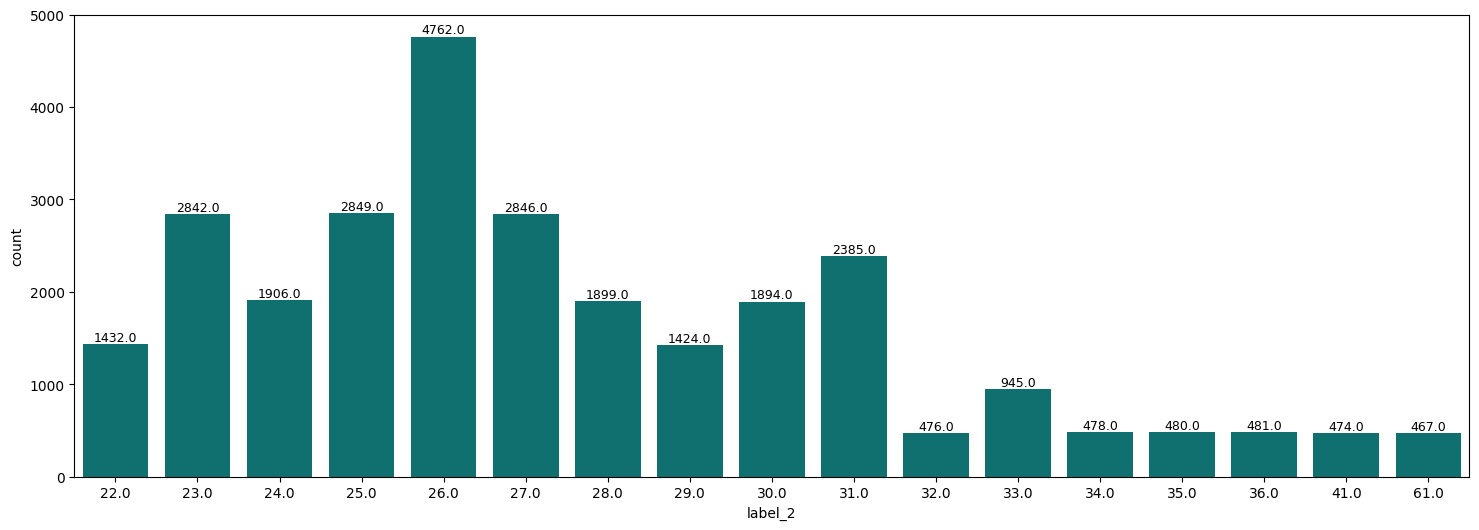

In [30]:
plt.figure(figsize=(18, 6))
ax = sn.countplot(x=y_train['label_2'], color='teal')

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=9, color='black')

In [31]:
ros = RandomOverSampler(random_state=0)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train['label_2'])

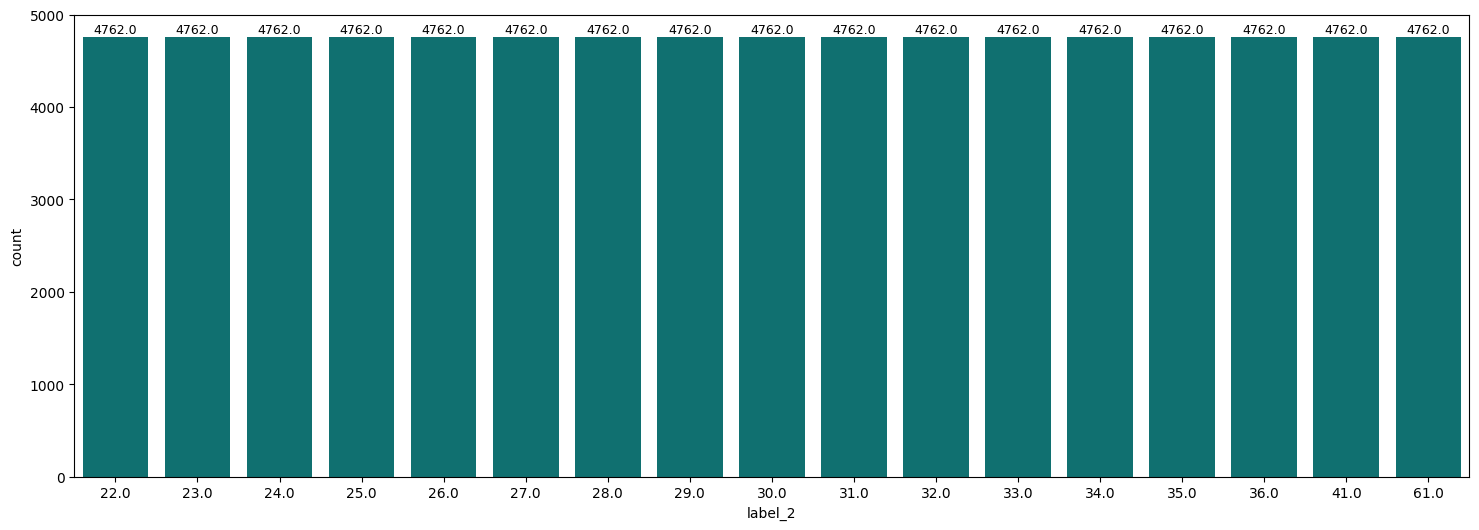

In [32]:
plt.figure(figsize=(18, 6))
ax = sn.countplot(x=y_train_resampled, color='teal')

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=9, color='black')

In [33]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [34]:
X_train_scaled.shape

(80954, 768)

In [35]:
# accuracy with all the features
#svm
start_time = time.time()
accuracy = svm_classifier(X_train_scaled, y_train_resampled, X_val, y_val['label_2'] )
elapsed_time = time.time() - start_time
print(f"Accuracy: {accuracy * 100:.2f}% in {elapsed_time} secs")

Accuracy: 11.55% in 767.6966035366058 secs


In [36]:
# accuracy with all the features
#knn
start_time = time.time()
accuracy = knn_classifier(X_train_scaled, y_train_resampled, X_val, y_val['label_2'] )
elapsed_time = time.time() - start_time
print(f"Accuracy: {accuracy * 100:.2f}% in {elapsed_time} secs")

Accuracy: 11.14% in 2.309518575668335 secs


In [37]:
# accuracy with all the features
#logistic_regression_classifier
start_time = time.time()
accuracy = logistic_regression_classifier(X_train, y_train['label_2'], X_val, y_val['label_2'] )
elapsed_time = time.time() - start_time
print(f"Accuracy: {accuracy * 100:.2f}% in {elapsed_time} secs")

Accuracy: 17.12% in 22.338536739349365 secs


In [38]:
pca = PCA(n_components=0.98, svd_solver = 'full')
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

In [39]:
X_train_pca.shape

(80954, 274)

In [40]:
# # defining parameter range
# param_grid = {'depth': [6, 8],
#               'learning_rate' : [0.01, 0.05, 0.1],
#               'iterations': [100]}

# # Create a CatBoostClassifier object
# cb = CatBoostClassifier(task_type="GPU")

# # Create GridSearchCV object
# grid = GridSearchCV(cb, param_grid, cv=3, verbose=2)

# # fitting the model for grid search
# grid.fit(X_train_pca, y_train_resampled)

# # get the best parameters
# grid.best_params_

In [41]:
# # Define parameter range
# param_grid = {'C': [100,1000], 
#               'gamma': [ 0.1, 0.01],
#               'kernel': ['rbf']}

# # Create a SVM object
# svc = SVC()

# # Create GridSearchCV object
# grid = GridSearchCV(svc, param_grid, cv=3, verbose=2)

# # Fit the model for grid search
# grid.fit(X_train_pca, y_train_resampled)

# # Get the best parameters
# grid.best_params_

In [42]:
# # Create a CatBoostClassifier object
# cb = CatBoostClassifier(depth=8, learning_rate=0.1, iterations=100,task_type="GPU")

# # Perform cross-validation and compute the mean score
# cross_val_score(cb, X_train_pca, y_train_resampled, cv=3).mean()

In [43]:
# best_model_label_2 = CatBoostClassifier(depth=8, learning_rate=0.1, iterations=100,task_type="GPU")
# best_model_label_2.fit(X_train_pca, y_train_resampled)

In [44]:
cross_val_score(SVC(C=1000, gamma=0.01, kernel='rbf'), X_train_pca, y_train_resampled, cv=3).mean()

0.9420042333730918

In [45]:
best_model_label_2 = SVC(C=1000, gamma=0.01, kernel='rbf', probability=True)
best_model_label_2.fit(X_train_pca, y_train_resampled)

SVC(C=1000, gamma=0.01, probability=True)

In [46]:
label_2_pred_after = best_model_label_2.predict(np.array(X_test_pca))

# Label 3

In [47]:
label_3_train = train.copy()
label_3_valid = valid.copy()
label_3_test = test.copy()

In [48]:
label_3_train = label_3_train.dropna(subset=['label_3'])
label_3_valid = label_3_valid.dropna(subset=['label_3'])

In [49]:
X_train = label_3_train.iloc[:, :-4]
y_train = label_3_train.iloc[:, -2:]
X_val = label_3_valid.iloc[:, :-4]
y_val = label_3_valid.iloc[:, -2:]
X_test = label_3_test.iloc[:, 1:]

<Axes: xlabel='label_3', ylabel='Count'>

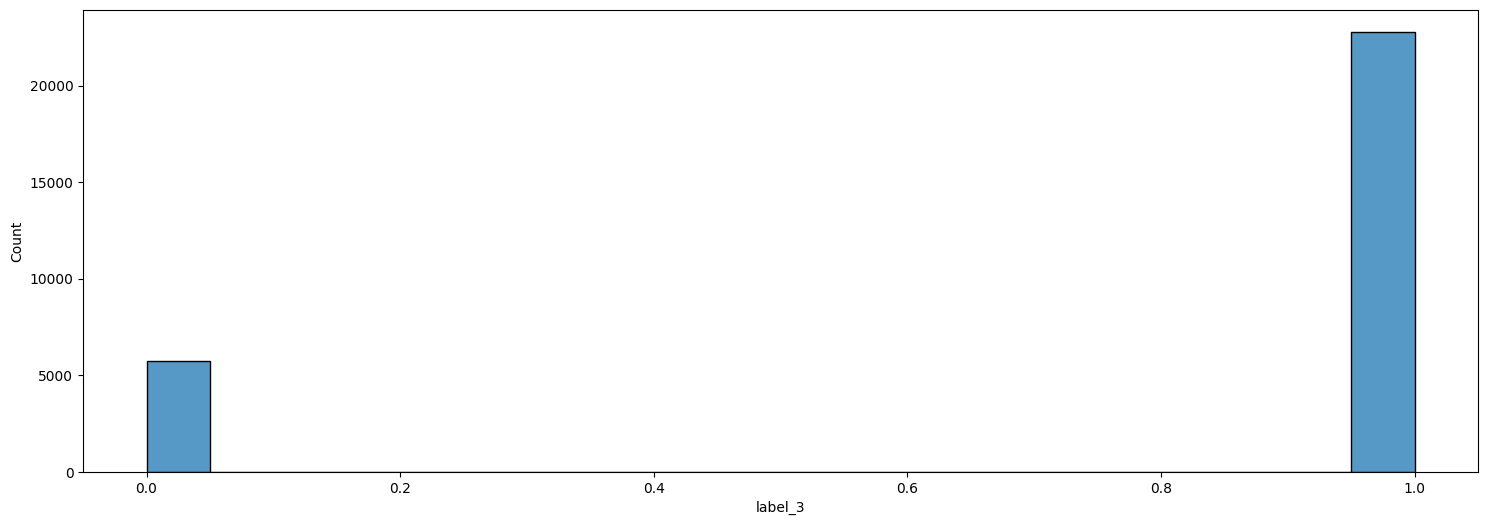

In [50]:
plt.figure(figsize=(18, 6))
sn.histplot(data=y_train, x='label_3', bins=20, kde=False)

In [51]:
ros = RandomOverSampler(random_state=0, sampling_strategy=0.75)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train['label_3'])

In [52]:
y_train_resampled

0        1
1        1
2        1
3        1
4        1
        ..
39888    0
39889    0
39890    0
39891    0
39892    0
Name: label_3, Length: 39893, dtype: int64

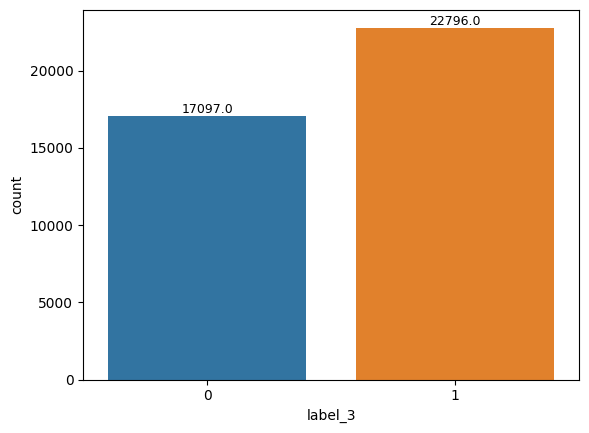

In [53]:
ax = sn.countplot(x=y_train_resampled)

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=9, color='black')

In [54]:
# accuracy with all the features
#svm
start_time = time.time()
accuracy = svm_classifier(X_train_resampled, y_train_resampled, X_val, y_val['label_3'] )
elapsed_time = time.time() - start_time
print(f"Accuracy: {accuracy * 100:.2f}% in {elapsed_time} secs")

Accuracy: 85.73% in 96.37975192070007 secs


In [55]:
# accuracy with all the features
#knn
start_time = time.time()
accuracy = knn_classifier(X_train_resampled, y_train_resampled, X_val, y_val['label_3'] )
elapsed_time = time.time() - start_time
print(f"Accuracy: {accuracy * 100:.2f}% in {elapsed_time} secs")

Accuracy: 78.80% in 1.3212523460388184 secs


In [56]:
# accuracy with all the features
#logistic_regression_classifier
start_time = time.time()
accuracy = logistic_regression_classifier(X_train_resampled, y_train_resampled, X_val, y_val['label_3'] )
elapsed_time = time.time() - start_time
print(f"Accuracy: {accuracy * 100:.2f}% in {elapsed_time} secs")

Accuracy: 88.27% in 4.740875482559204 secs


In [57]:
# accuracy with all the features
# catboost_classifier
start_time = time.time()
accuracy = catboost_classifier(X_train_resampled, y_train_resampled, X_val, y_val['label_3'] )
elapsed_time = time.time() - start_time
print(f"Accuracy: {accuracy * 100:.2f}% in {elapsed_time} secs")

Learning rate set to 0.049718
0:	learn: 0.6624670	total: 343ms	remaining: 5m 42s
1:	learn: 0.6361635	total: 571ms	remaining: 4m 45s
2:	learn: 0.6124126	total: 796ms	remaining: 4m 24s
3:	learn: 0.5909694	total: 1.01s	remaining: 4m 12s
4:	learn: 0.5702891	total: 1.24s	remaining: 4m 5s
5:	learn: 0.5522890	total: 1.46s	remaining: 4m 2s
6:	learn: 0.5347580	total: 1.7s	remaining: 4m
7:	learn: 0.5204252	total: 1.91s	remaining: 3m 57s
8:	learn: 0.5051076	total: 2.13s	remaining: 3m 55s
9:	learn: 0.4889241	total: 2.36s	remaining: 3m 53s
10:	learn: 0.4755858	total: 2.56s	remaining: 3m 50s
11:	learn: 0.4627174	total: 2.79s	remaining: 3m 49s
12:	learn: 0.4518939	total: 3.01s	remaining: 3m 48s
13:	learn: 0.4411343	total: 3.23s	remaining: 3m 47s
14:	learn: 0.4315392	total: 3.47s	remaining: 3m 47s
15:	learn: 0.4217272	total: 3.69s	remaining: 3m 47s
16:	learn: 0.4120089	total: 3.92s	remaining: 3m 46s
17:	learn: 0.4025341	total: 4.14s	remaining: 3m 45s
18:	learn: 0.3944356	total: 4.35s	remaining: 3m 44s

In [58]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [59]:
pca = PCA(n_components=0.98, svd_solver = 'full')
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

In [60]:
X_train_pca.shape

(39893, 276)

In [61]:
# # defining parameter range
# param_grid = {'depth': [6, 8],
#               'learning_rate' : [0.01, 0.05, 0.1],
#               'iterations': [100]}

# # Create a CatBoostClassifier object
# cb = CatBoostClassifier(task_type="GPU")

# # Create GridSearchCV object
# grid = GridSearchCV(cb, param_grid, cv=3, verbose=2)

# # fitting the model for grid search
# grid.fit(X_train_pca, y_train_resampled)

# # get the best parameters
# grid.best_params_

In [62]:
# # Define parameter range
# param_grid = {'C': [100,1000], 
#               'gamma': [ 0.1, 0.01],
#               'kernel': ['rbf']}

# # Create a SVM object
# svc = SVC()

# # Create GridSearchCV object
# grid = GridSearchCV(svc, param_grid, cv=3, verbose=2)

# # Fit the model for grid search
# grid.fit(X_train_pca, y_train_resampled)

# # Get the best parameters
# grid.best_params_

In [63]:
# # Create a CatBoostClassifier object
# cb = CatBoostClassifier(depth=8, learning_rate=0.1, iterations=100,task_type="GPU")

# # Perform cross-validation and compute the mean score
# cross_val_score(cb, X_train_pca, y_train_resampled, cv=3).mean()

In [64]:
cross_val_score(SVC(C=1000, gamma=0.01, kernel='rbf'), X_train_pca, y_train_resampled, cv=3).mean()

0.9925552281116591

In [65]:
best_model_label_3 = SVC(C=1000, gamma=0.01, kernel='rbf')
best_model_label_3.fit(X_train_pca, y_train_resampled)

SVC(C=1000, gamma=0.01)

In [66]:
label_3_pred_after = best_model_label_3.predict(np.array(X_test_pca))

# Label 4

In [67]:
label_4_train = train.copy()
label_4_valid = valid.copy()
label_4_test = test.copy()

In [68]:
label_4_train = label_4_train.dropna(subset=['label_4'])
label_4_valid = label_4_valid.dropna(subset=['label_4'])

In [69]:
X_train = label_4_train.iloc[:, :-4]
y_train = label_4_train.iloc[:, -1:]
X_val = label_4_valid.iloc[:, :-4]
y_val = label_4_valid.iloc[:, -1:]
X_test = label_4_test.iloc[:, 1:]

<Axes: xlabel='label_4', ylabel='Count'>

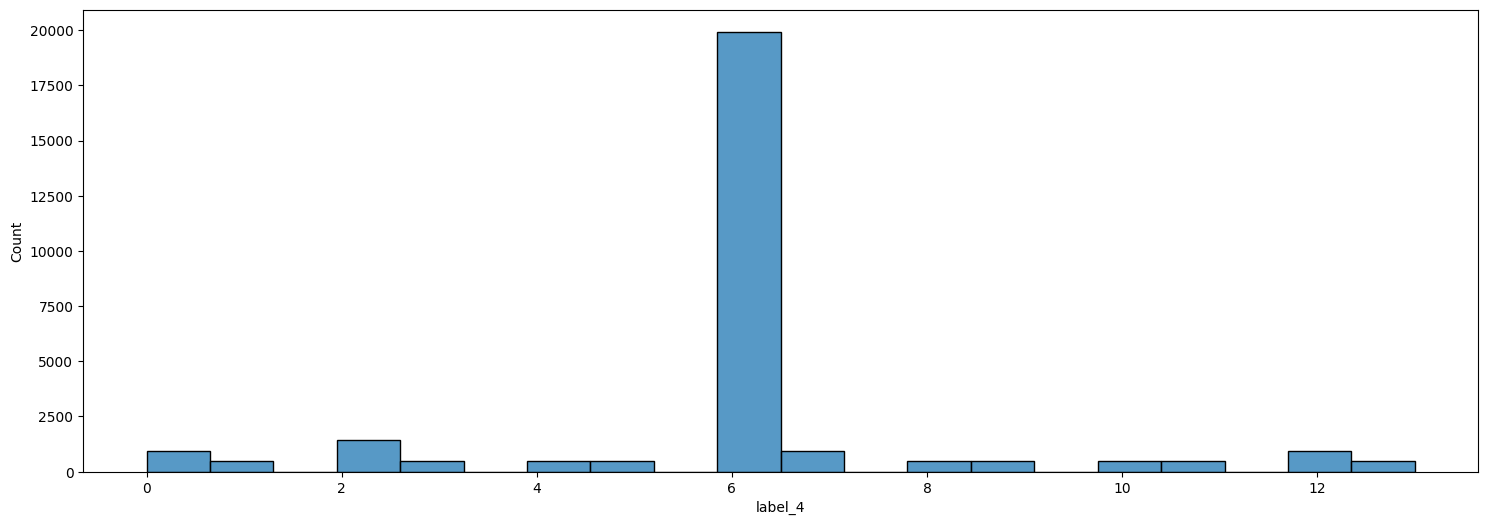

In [70]:
plt.figure(figsize=(18, 6))
sn.histplot(data=y_train, x='label_4', bins=20, kde=False)

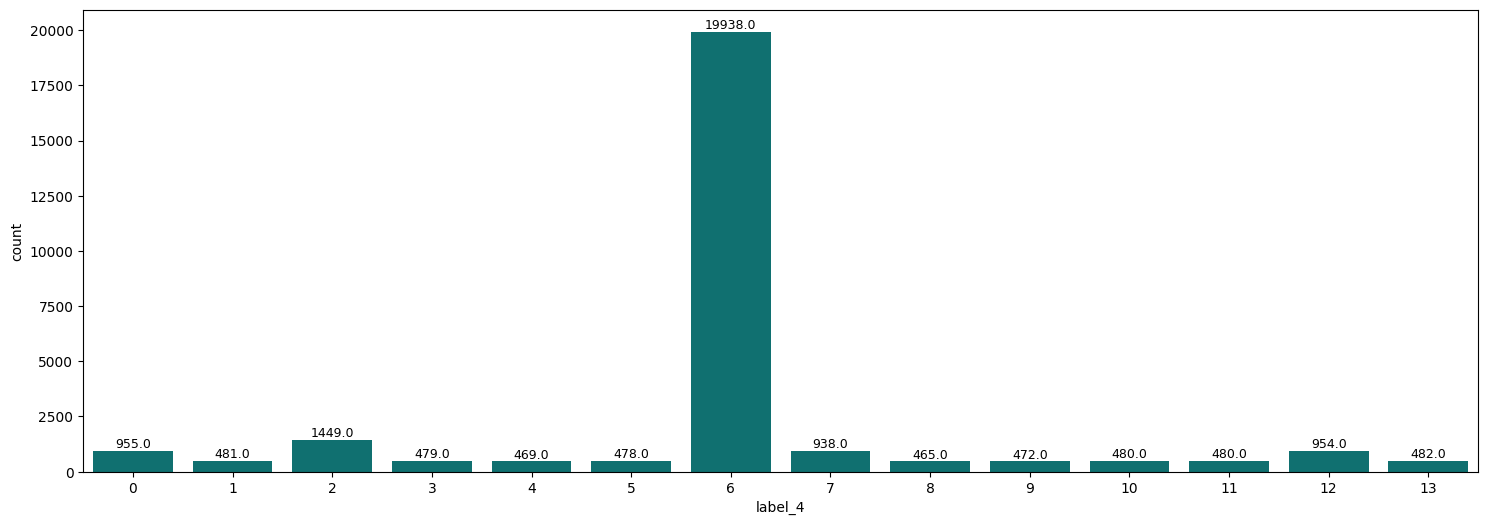

In [71]:
plt.figure(figsize=(18, 6))
ax = sn.countplot(x=y_train['label_4'], color='teal')

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=9, color='black')

In [72]:
# accuracy with all the features
#knn
start_time = time.time()
accuracy = knn_classifier(X_train, y_train, X_val, y_val['label_4'] )
elapsed_time = time.time() - start_time
print(f"Accuracy: {accuracy * 100:.2f}% in {elapsed_time} secs")

Accuracy: 54.00% in 1.1435534954071045 secs


In [73]:
ros = RandomOverSampler(random_state=0)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train['label_4'])

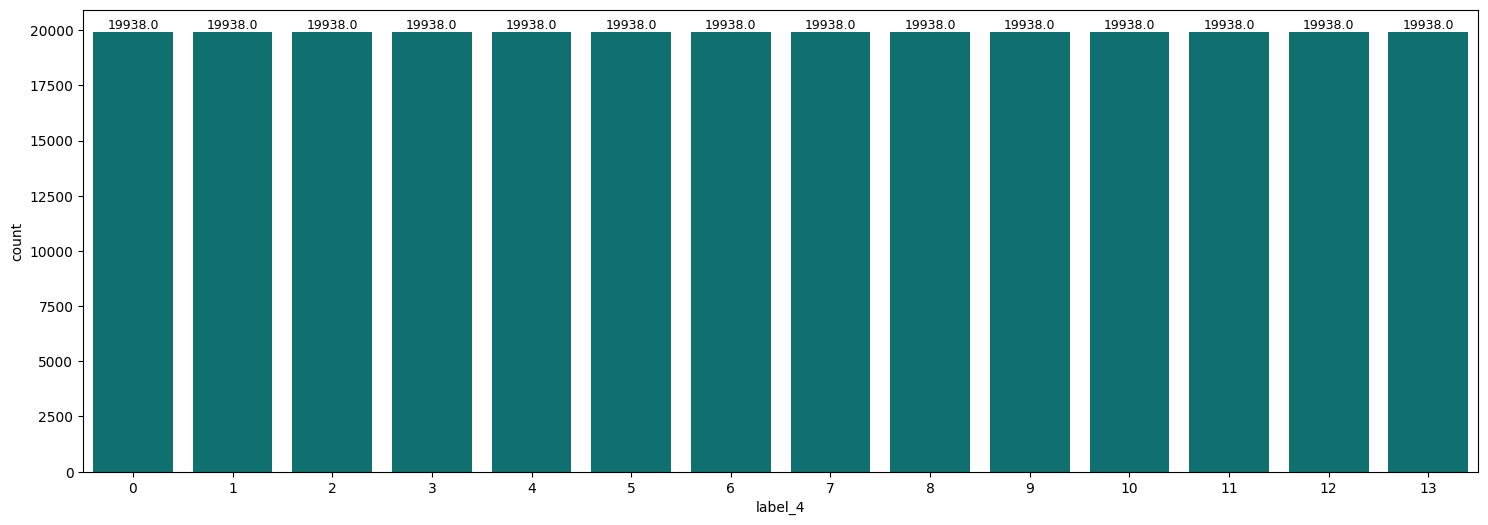

In [74]:
plt.figure(figsize=(18, 6))
ax = sn.countplot(x=y_train_resampled, color='teal')

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=9, color='black')

In [75]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [76]:
pca = PCA(n_components=0.98, svd_solver = 'full')
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [77]:
X_train_pca.shape

(279132, 261)

In [78]:
# # defining parameter range
# param_grid = {'depth': [6, 8],
#               'learning_rate' : [0.01, 0.05, 0.1],
#               'iterations': [100]}

# # Create a CatBoostClassifier object
# cb = CatBoostClassifier(task_type="GPU")

# # Create GridSearchCV object
# grid = GridSearchCV(cb, param_grid, cv=3, verbose=2)

# # fitting the model for grid search
# grid.fit(X_train_pca, y_train_resampled)

# # get the best parameters
# grid.best_params_

In [79]:
# # Define parameter range
# param_grid = {'C': [100,1000], 
#               'gamma': [ 0.1, 0.01],
#               'kernel': ['rbf']}

# # Create a SVM object
# svc = SVC()

# # Create GridSearchCV object
# grid = GridSearchCV(svc, param_grid, cv=3, verbose=2)

# # Fit the model for grid search
# grid.fit(X_train_pca, y_train_resampled)

# # Get the best parameters
# grid.best_params_

In [80]:
# cb = CatBoostClassifier(depth=8, learning_rate=0.1, iterations=100,task_type="GPU")
# cross_val_score(cb, X_train_pca, y_train_resampled, cv=3).mean()

In [81]:
# accuracy with all the features
#svm
start_time = time.time()
accuracy = svm_classifier(X_train_resampled, y_train_resampled, X_val, y_val['label_4'] )
elapsed_time = time.time() - start_time
print(f"Accuracy: {accuracy * 100:.2f}% in {elapsed_time} secs")

Accuracy: 5.87% in 5048.714841842651 secs


In [82]:
# accuracy with all the features
#knn
start_time = time.time()
accuracy = knn_classifier(X_train_resampled, y_train_resampled, X_val, y_val['label_4'] )
elapsed_time = time.time() - start_time
print(f"Accuracy: {accuracy * 100:.2f}% in {elapsed_time} secs")

Accuracy: 54.00% in 12.026458024978638 secs


In [83]:
# accuracy with all the features
#logistic_regression_classifier
start_time = time.time()
accuracy = logistic_regression_classifier(X_train_resampled, y_train_resampled, X_val, y_val['label_4'] )
elapsed_time = time.time() - start_time
print(f"Accuracy: {accuracy * 100:.2f}% in {elapsed_time} secs")

Accuracy: 7.33% in 158.33134198188782 secs


In [84]:
cross_val_score(SVC(C=1000, gamma=0.01, kernel='rbf'), X_train_pca, y_train_resampled, cv=3).mean()

0.9977895762578278

In [85]:
# best_model_label_4 = CatBoostClassifier(depth=8, learning_rate=0.1, iterations=100,task_type="GPU")
# best_model_label_4.fit(X_train_pca, y_train_resampled)

In [86]:
best_model_label_4 = SVC(C=1000, gamma=0.01, kernel='rbf')
best_model_label_4.fit(X_train_pca, y_train_resampled)

SVC(C=1000, gamma=0.01)

In [87]:
label_4_pred_after = best_model_label_4.predict(np.array(X_test_pca))

# Kaggle competition output

In [88]:
output_df = test[['ID']]
output_df['label_1'] = label_1_pred_after
output_df['label_2'] = label_2_pred_after
output_df['label_3'] = label_3_pred_after
output_df['label_4'] = label_4_pred_after

In [89]:
output_df.head()

,ID,label_1,label_2,label_3,label_4
0,1,26,23.0,1,6
1,2,18,23.0,1,6
2,3,16,23.0,1,6
3,4,7,23.0,1,6
4,5,58,23.0,1,6


In [90]:
output_df.to_csv('predictions_L12_fsvm.csv', index=False)